# Language Modelling with Transformers

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

We're going to be interested in predicting the next subword token. How many possible subword tokens are there?

In [2]:
len(tokenizer.vocab), len(tokenizer)  # or we could just use len(tokenizer)

(50257, 50257)

When tokenizing, we'll use the tokenizer with the `return_tensors='pt'` parameter. This puts the data into the format of a [PyTorch](https://pytorch.org) tensor which is used as the input for a Transformer model. PyTorch is a commonly used library for deep learning and HuggingFace builds upon it. We won't use PyTorch directly.

Let's tokenize: `"A horse! a horse! my kingdom for a"`

In [3]:
tokenized = tokenizer('A horse! a horse! my kingdom for a', return_tensors='pt')
tokenized

{'input_ids': tensor([[   32,  8223,     0,   257,  8223,     0,   616, 13239,   329,   257]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [4]:
len(tokenized['input_ids'][0])

10

Now we need to load up the full Transformer model. We need to use the same one that matches our tokenizer (`distilgpt2`). Tokenizers and models must match.

We'll load it using `AutoModelForCausalLM`. CausalLM is causal language modelling, or predicting the next token. You can also load models for other purposes like document classification.

In [5]:
model = AutoModelForCausalLM.from_pretrained('distilgpt2')

Now let's pass the tokenized text into the Transformer model. We could do this with `model(input_ids=tokenized['input_ids'], attention_mask=tokenized['attention_mask'])` but a tidied shorthand is:

In [6]:
output = model(**tokenized)

For causal language modelling, what we care about is the predictions of the next token. This is captured by the `logits` which are the scores for each of the possible tokens.

In [7]:
output.logits

tensor([[[-31.1439, -29.1283, -30.8418,  ..., -42.3130, -42.1440, -31.0009],
         [-59.5865, -60.5802, -64.7680,  ..., -70.8865, -65.8932, -63.0499],
         [-62.7691, -63.7442, -64.5699,  ..., -75.1834, -72.3489, -60.4002],
         ...,
         [-51.0393, -59.1055, -63.8448,  ..., -68.9364, -65.0198, -59.6002],
         [-56.1765, -60.0482, -63.8827,  ..., -66.6802, -65.5936, -61.3876],
         [-63.7612, -64.7149, -67.7764,  ..., -75.3739, -69.5853, -65.8061]]],
       grad_fn=<UnsafeViewBackward0>)

This is a PyTorch tensor which is a grid of numbers. In this case, it's a 3D grid. You can see the dimensions of it using `.shape` as below:

In [8]:
output.logits.shape

torch.Size([1, 10, 50257])

Where do the different numbers come from?

Well we only put in one sequence of ten words, so that explains the `[1, 10,...]`. The `50257` is the size of the vocabulary of the tokenizer:

In [9]:
len(tokenizer)

50257

That means we can get the score that the Transformer has given to token `horse` after the final token in the sequence with. First, what is the token index for horse? Recall that as it is starting a new word, there is the special character of `Ġ`.

In [10]:
tokenizer.vocab['Ġhorse']

8223

Then to get the score from the first sequence (0), after the final token (-1) and for the token `horse` (8223), we would access it with:

This expression retrieves the logit (raw, unnormalized score) assigned by the Transformer model to the token with index `8223` (which corresponds to the token `'Ġhorse'`) after processing the input sequence.

- `output.logits` is a 3D tensor of shape `[batch_size, sequence_length, vocab_size]`.
- `[0, -1, 8223]` means:
  - `0`: the first (and only) sequence in the batch,
  - `-1`: the last position in the sequence (i.e., after the final input token),
  - `8223`: the vocabulary index for the token `'Ġhorse'`.

So, `output.logits[0, -1, 8223]` gives the model's score for predicting `'Ġhorse'` as the next token after the input sequence.

In [11]:
output.logits[0, -1, 8223]

tensor(-59.6236, grad_fn=<SelectBackward0>)

Hmm, the logits are not nicely probabilities so are difficult to interpret. We'll have to do a little work to make them interpretable.

Let's get all the scores out for predictions of tokens after our input (so using the index of -1 to get the final logits).

In [12]:
next_token_scores = output.logits[0, -1, :].tolist()
len(next_token_scores)

50257

As we already saw, they are not easy to interpret.

In [13]:
next_token_scores[:5]

[-63.76117706298828,
 -64.71490478515625,
 -67.77635955810547,
 -67.36964416503906,
 -67.9713134765625]

So we shall use a softmax function. It takes a list of numbers, applies the equation below to them (using lots of exponentials) and returns a vector where all the values are between 0 and 1 and they all add up to 1.

$ softmax(z) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K $

There is a [function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html) in the useful [scipy package](https://scipy.org/) that does this for us.

Apply the `softmax` function to `next_token_scores` and output the first five values. You should see that they are between 0 and 1 and rather small.

In [14]:
softmax(next_token_scores)

array([9.37577501e-05, 3.61250528e-05, 1.69135813e-06, ...,
       8.48538825e-10, 2.77092127e-07, 1.21316209e-05], shape=(50257,))

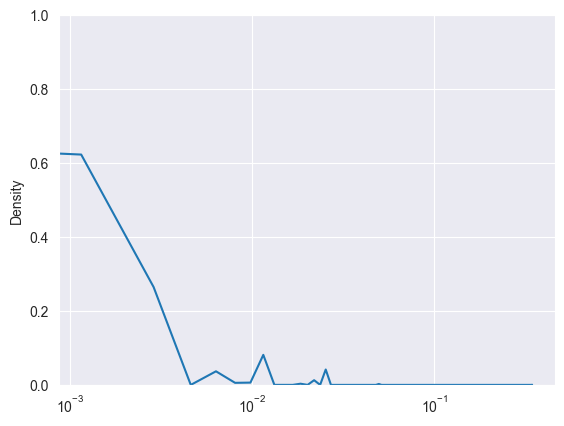

In [15]:
sns.kdeplot(softmax(next_token_scores))
plt.xscale('log')
plt.ylim(0, 1)
plt.yscale('linear')
plt.show()

The probabilities should also add up to 1 (or very close due to little numerical differences).

In [16]:
sum(softmax(next_token_scores))

np.float64(1.0000000000000095)

Let's see what the probability of horse is now (token id = 8223)

In [17]:
softmax(next_token_scores)[tokenizer.vocab['Ġhorse']]

np.float64(0.005873710318478227)

In [18]:
softmax(next_token_scores)[8223]

np.float64(0.005873710318478227)

You should find that it has a probability of approximately `0.006`.

If we didn't already know that 8223 is horse, we could decode it with the tokenizer.

In [19]:
tokenizer.decode(8223)

' horse'

Now, the final task is going through the `next_token_probs` and finding which one has the highest probability and figuring out the corresponding token using `tokenizer.decode`.

In [21]:
next_token_probs = softmax(next_token_scores)
max_index = np.argmax(next_token_probs)
print(f"Max index: {max_index}, Token: {tokenizer.decode(max_index)}, Probability: {next_token_probs[max_index]}")

Max index: 890, Token:  long, Probability: 0.3426657343488758


You should find that `' long'` has the highest probability (`≈ 0.3427`)